In [1]:
### CELL-2 ###
# Load the raw CIFAR-10 data
from data_utils import load_CIFAR10

cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [2]:
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils, layers, activations, models, losses, optimizers, metrics, callbacks, datasets, preprocessing

In [4]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [5]:
train_data, train_label, test_data, test_label = load_CIFAR10(cifar10_dir)

In [6]:
# Normalizing
train_data_proc = train_data / 255
test_data_proc = test_data / 255

#One hot encoding
train_label_proc = utils.to_categorical(train_label, 10)
test_label_proc = utils.to_categorical(test_label, 10)

In [7]:
image_gen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.3
)
train_gen = image_gen.flow(train_data_proc, train_label_proc, batch_size=128)

In [8]:
mInput = layers.Input((32, 32, 3))

In [9]:
mB1 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B1_Conv_1")(mInput)
mB1 = layers.BatchNormalization(name="B1_Norm_1")(mB1)
mB1 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B1_Conv_2")(mB1)
mB1 = layers.BatchNormalization(name="B1_Norm_2")(mB1)
mB1 = layers.MaxPool2D(2, strides=1, name="B1_Pool")(mB1)
mB1 = layers.Dropout(0.5, name="B1_Drop")(mB1)

In [10]:
mB2 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B2_Conv_1")(mB1)
mB2 = layers.BatchNormalization(name="B2_Norm_1")(mB2)
mB2 = layers.Conv2D(128, 3, dilation_rate=2, activation="relu", name="B2_Conv_2")(mB2)
mB2 = layers.BatchNormalization(name="B2_Norm_2")(mB2)
mB2 = layers.MaxPool2D(2, strides=1, name="B2_Pool")(mB2)
mB2 = layers.Dropout(0.5, name="B2_Drop")(mB2)

In [11]:
mB3     = layers.Conv2D(128, 3, padding="same", activation="relu", name="B3_Conv_1")(mB1)
mB3     = layers.BatchNormalization(name="B3_Norm_1")(mB3)
mB3     = layers.Conv2D(256, 3, padding="same", dilation_rate=2, activation="relu", name="B3_Conv_2")(mB3)
mB3     = layers.BatchNormalization(name="B3_Norm_2")(mB3)
mB3Pool = layers.MaxPool2D(2, strides=1, name="B3_Pool")(mB3)
mB3     = layers.Dropout(0.5, name="B3_Drop")(mB3Pool)

mB4     = layers.Conv2D(128, 3, padding="same", activation="relu", name="B4_Conv_1")(mB3)
mB4     = layers.BatchNormalization(name="B4_Norm_1")(mB4)
mB4     = layers.Conv2D(256, 3, padding="same", activation="relu", name="B4_Conv_2")(mB4)
mB4     = layers.add([mB4, mB3Pool], name="B4_Add")
mB4Nor  = layers.BatchNormalization(name="B4_Norm_2")(mB4)
mB4Dout = layers.Dropout(0.5, name="B4_Drop")(mB4Nor)

mB5 = layers.Conv2D(128, 3, dilation_rate=2, padding="same", activation="relu", name="B5_Conv_1")(mB4Nor)
mB5 = layers.BatchNormalization(name="B5_Norm")(mB5)
mB5 = layers.Conv2D(256, 3, dilation_rate=3, padding="same", activation="relu", name="B5_Conv_2")(mB5)

mB6 = layers.Conv2D(128, 5, padding="same", activation="relu", name="B6_Conv_1")(mB4Nor)
mB6 = layers.BatchNormalization(name="B6_Norm")(mB6)
mB6 = layers.Conv2D(256, 5, padding="same", activation="relu", name="B6_Conv_2")(mB6)

mB7 = layers.Conv2D(128, 3, padding="same", activation="relu", name="B7_Conv_1")(mB4Dout)
mB7 = layers.BatchNormalization(name="B7_Norm_1")(mB7)
mB7 = layers.Conv2D(256, 3, padding="same", activation="relu", name="B7_Conv_2")(mB7)
mB7 = layers.add([mB5, mB6, mB7], name="B7_Add")
mB7 = layers.BatchNormalization(name="B7_Norm_2")(mB7)
mB7 = layers.Dropout(0.5, name="B7_Drop")(mB7)

mB8 = layers.Conv2D(128, 3, padding="same", activation="relu", name="B8_Conv_1")(mB7)
mB8 = layers.BatchNormalization(name="B8_Norm_1")(mB8)
mB8 = layers.Conv2D(256, 3, padding="same", dilation_rate=2, activation="relu", name="B8_Conv_2")(mB8)
mB8 = layers.add([mB3Pool, mB5, mB7, mB8], name="B8_Add")
mB8 = layers.BatchNormalization(name="B8_Norm_2")(mB8)
mB8 = layers.Dropout(0.5, name="B8_Drop")(mB8)

mB9 = layers.Conv2D(256, 3, activation="relu", name="B9_Conv_1")(mB8)
mB9 = layers.BatchNormalization(name="B9_Norm_1")(mB9)
mB9 = layers.Conv2D(256, 3, dilation_rate=2, activation="relu", name="B9_Conv_2")(mB9)
mB9 = layers.BatchNormalization(name="B9_Norm_2")(mB9)
mB9 = layers.MaxPool2D(2, name="B9_Pool")(mB9)
mB9 = layers.Dropout(0.5, name="B9_Drop")(mB9)

mB10 = layers.Conv2D(512, 3, padding="same", activation="relu", name="B8_Conv")(mB9)
mB10 = layers.GlobalAveragePooling2D(name="B10_Pool")(mB10)
mB10 = layers.BatchNormalization(name="B10_Norm")(mB10)

mOutput = layers.Dense(10, activation="softmax", name="Output")(mB10)

model = models.Model(mInput, mOutput)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
B1_Conv_1 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
B1_Norm_1 (BatchNormalization)  (None, 32, 32, 64)   256         B1_Conv_1[0][0]                  
__________________________________________________________________________________________________
B1_Conv_2 (Conv2D)              (None, 32, 32, 64)   36928       B1_Norm_1[0][0]                  
______________________________________________________________________________________________

In [12]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

In [13]:
history_aug = model.fit(
    train_gen,
    epochs=80,
    validation_data=(test_data_proc, test_label_proc),
 )

  ...
    to  
  ['...']
Train for 391 steps, validate on 10000 samples
Epoch 1/80
391/391 [==============================] - 202s 518ms/step - loss: 1.7200 - accuracy: 0.3769 - val_loss: 2.6981 - val_accuracy: 0.1630
Epoch 2/80
391/391 [==============================] - 198s 505ms/step - loss: 1.3240 - accuracy: 0.5251 - val_loss: 1.4728 - val_accuracy: 0.5497
Epoch 3/80
391/391 [==============================] - 195s 498ms/step - loss: 1.1127 - accuracy: 0.6047 - val_loss: 1.6493 - val_accuracy: 0.5586
Epoch 4/80
391/391 [==============================] - 194s 495ms/step - loss: 0.9727 - accuracy: 0.6564 - val_loss: 1.2074 - val_accuracy: 0.6433
Epoch 5/80
391/391 [==============================] - 194s 495ms/step - loss: 0.8556 - accuracy: 0.7043 - val_loss: 0.8004 - val_accuracy: 0.7358
Epoch 6/80
391/391 [==============================] - 193s 492ms/step - loss: 0.7782 - accuracy: 0.7307 - val_loss: 0.8793 - val_accuracy: 0.7206
Epoch 7/80
391/391 [==============================] 

Epoch 56/80
391/391 [==============================] - 192s 491ms/step - loss: 0.1845 - accuracy: 0.9360 - val_loss: 0.4585 - val_accuracy: 0.8903
Epoch 57/80
391/391 [==============================] - 192s 491ms/step - loss: 0.1777 - accuracy: 0.9376 - val_loss: 0.3966 - val_accuracy: 0.8995
Epoch 58/80
391/391 [==============================] - 193s 493ms/step - loss: 0.1809 - accuracy: 0.9373 - val_loss: 0.3586 - val_accuracy: 0.9075
Epoch 59/80
391/391 [==============================] - 194s 495ms/step - loss: 0.1771 - accuracy: 0.9384 - val_loss: 0.3852 - val_accuracy: 0.9061
Epoch 60/80
391/391 [==============================] - 194s 495ms/step - loss: 0.1727 - accuracy: 0.9402 - val_loss: 0.3667 - val_accuracy: 0.9070
Epoch 61/80
391/391 [==============================] - 193s 495ms/step - loss: 0.1736 - accuracy: 0.9397 - val_loss: 0.6484 - val_accuracy: 0.8669
Epoch 62/80
391/391 [==============================] - 192s 491ms/step - loss: 0.1667 - accuracy: 0.9418 - val_loss: 0

<AxesSubplot:>

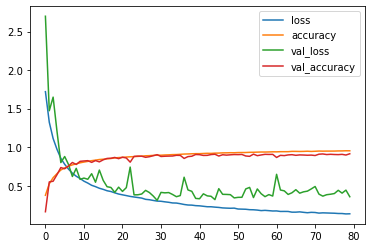

In [14]:
pd.DataFrame(history_aug.history).plot()

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

@interact(idx=(0, 9999, 1))
def showTestImage(idx):
    data = test_data[idx].reshape(-1, 32, 32, 3)/255.0
    dataPred = model.predict(data)
    
    plt.imshow(test_data[idx].astype('uint16'))
    plt.grid(False)
    plt.title(f"LABEL: {class_names[test_label[idx]]}, PREDICT: {class_names[np.argmax(dataPred)]}")
    plt.show()

interactive(children=(IntSlider(value=4999, description='idx', max=9999), Output()), _dom_classes=('widget-int…

In [16]:
err_idx = []
pred_result = model.predict(test_data_proc)

for idx in range(10000):
    if np.argmax(pred_result[idx]) != test_label[idx]:
        err_idx.append(idx)

In [17]:
len(err_idx), err_idx

(851,
 [37,
  52,
  58,
  74,
  78,
  85,
  118,
  147,
  158,
  164,
  188,
  195,
  210,
  213,
  224,
  226,
  264,
  265,
  277,
  287,
  293,
  308,
  312,
  313,
  316,
  355,
  368,
  376,
  378,
  384,
  387,
  401,
  405,
  422,
  423,
  426,
  439,
  456,
  470,
  478,
  488,
  497,
  518,
  526,
  531,
  539,
  598,
  640,
  641,
  642,
  645,
  675,
  683,
  689,
  725,
  731,
  739,
  770,
  775,
  779,
  792,
  797,
  798,
  811,
  845,
  857,
  875,
  877,
  882,
  883,
  885,
  888,
  893,
  900,
  910,
  916,
  924,
  925,
  933,
  943,
  948,
  956,
  972,
  982,
  1001,
  1019,
  1095,
  1118,
  1137,
  1163,
  1165,
  1166,
  1172,
  1177,
  1181,
  1208,
  1222,
  1227,
  1236,
  1247,
  1248,
  1277,
  1280,
  1306,
  1321,
  1322,
  1325,
  1328,
  1339,
  1353,
  1355,
  1393,
  1398,
  1408,
  1422,
  1429,
  1470,
  1492,
  1495,
  1496,
  1506,
  1521,
  1529,
  1536,
  1538,
  1547,
  1552,
  1572,
  1574,
  1577,
  1581,
  1587,
  1605,
  1607,
  1640,
  16